**Some required installation for `PYDICOM` data**. As stated in the [data section](https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/data):

> The **DICOM** image files are ≤ 1 mm slice thickness, axial orientation, and bone kernel. Note that some of the DICOM files are **JPEG compressed**. **You may require additional resources to read the pixel array of these files, such as GDCM and pylibjpeg.**

In [1]:
import os
import pydicom
import SimpleITK as sitk
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score
from multiprocessing import Pool

In [2]:
def load_dicom_image(file_path):
    dicom = sitk.ReadImage(file_path)
    img = sitk.GetArrayFromImage(dicom)[0]
    
    # Check if the image is a 2D array
    if img.ndim != 2:
        raise ValueError(f"Expected 2D image, got {img.ndim}D image")

    # Convert to uint8 if necessary
    if img.dtype != np.uint8:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Resize the image to 128x128
    img = cv2.resize(img, (128, 128))
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

In [3]:
def extract_images_from_subfolder(subfolder, limit_per_subfolder):
    file_paths = []
    count = 0
    with os.scandir(subfolder) as it:
        for entry in it:
            if entry.is_file() and entry.name.endswith('.dcm'):
                file_paths.append(entry.path)
                count += 1
                if count >= limit_per_subfolder:
                    break
    return file_paths

def extract_images_into_dataframe(directory, limit_per_subfolder=15):
    all_files = []
    subfolders = [f.path for f in os.scandir(directory) if f.is_dir()]
    
    with Pool(processes=os.cpu_count()) as pool:
        results = pool.starmap(extract_images_from_subfolder, [(subfolder, limit_per_subfolder) for subfolder in subfolders])
    
    for result in results:
        all_files.extend(result)
    
    df = pd.DataFrame({'FilePath': all_files})
    return df

In [4]:
# Define paths and parameters
main_folder_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images'
limit_per_subfolder = 15

# Extract 15 DICOM file paths per subfolder into a DataFrame
df = extract_images_into_dataframe(main_folder_path, limit_per_subfolder)

# Display the dataframe (optional)
print(df.shape)
print(df.head())

(30285, 1)
                                            FilePath
0  /kaggle/input/rsna-2022-cervical-spine-fractur...
1  /kaggle/input/rsna-2022-cervical-spine-fractur...
2  /kaggle/input/rsna-2022-cervical-spine-fractur...
3  /kaggle/input/rsna-2022-cervical-spine-fractur...
4  /kaggle/input/rsna-2022-cervical-spine-fractur...


In [5]:
# Load images and create arrays
images = []
for file_path in df['FilePath']:
    try:
        img = load_dicom_image(file_path)
        images.append(img)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

images = np.array(images)
print(images.shape)

(30285, 128, 128)


In [6]:
# Extract StudyInstanceUID from file paths
df['StudyInstanceUID'] = df['FilePath'].apply(lambda x: os.path.basename(os.path.dirname(x)))

# Merge with train.csv to get labels
train_df = pd.read_csv('/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train.csv')
df = df.merge(train_df[['StudyInstanceUID', 'patient_overall']], on='StudyInstanceUID', how='left')

# Extract labels
labels = df['patient_overall'].values
print(labels.shape)

# Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(30285,)
(24228, 128, 128) (24228,)
(6057, 128, 128) (6057,)


In [7]:
# Define and Train the Model
def create_model():
    inputs = Input(shape=(128, 128, 1))
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

# Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               737292

              precision    recall  f1-score   support

           0       0.76      0.73      0.75      3203
           1       0.71      0.74      0.73      2854

    accuracy                           0.74      6057
   macro avg       0.74      0.74      0.74      6057
weighted avg       0.74      0.74      0.74      6057

Accuracy: 0.7394749876176325


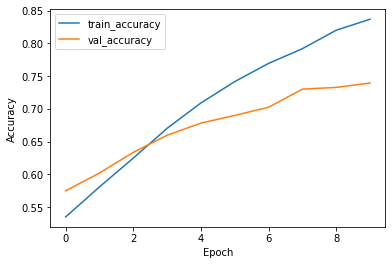

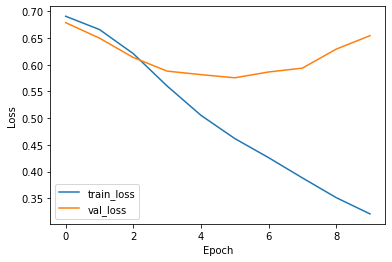

In [8]:
# Evaluate the Model
y_val_pred = model.predict(X_val)
y_val_pred = (y_val_pred > 0.5).astype(int)
print(classification_report(y_val, y_val_pred))
print('Accuracy:', accuracy_score(y_val, y_val_pred))

# Visualize Training History
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()